<a href="https://colab.research.google.com/github/kaspergroenbek98/first-first-year-project/blob/master/chaosBook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**All Imports**

In [0]:
! git clone https://github.com/kaspergroenbek98/first-first-year-project.git
### All import calls.
import numpy as np
import nltk
import csv
import nltk
import re
from collections import Counter
import pandas as pd
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import seaborn as sn
import matplotlib.pyplot as plt

#**Function Definitions and Vocabulary Construction**


In [0]:
### Functions

### START OF VOCABULARY ###
def generate_vocabulary(data, fCol, vocabType):
    '''
    Returns a list/vocabulary of len <= "size" based on the vocabType and the featureColumn specified
    '''
    size = 2000
    # Only get large groups to get representative data
    major_features = np.array(nltk.FreqDist(data[:,fCol]).most_common(5))
    major_masks = np.array([data[:,fCol] == f for (f, cnt) in major_features])
    fqs = [tweet_word_distribution(data[mask,:]) for mask in major_masks]
    return list(vocabType(data, fCol, major_features, major_masks, fqs, size))

def vocab_feature_most_common(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises the most common words for each feature
    '''
    vocabulary = set()
    # get the most common words in each freq dist. zip(*...) removes the counts from fd, and updates vocabulary ONLY with the words
    for fd in fqs:
        vocabulary.update(list(zip(*fd.most_common(size//len(major_features))))[0])
    return vocabulary

def vocab_feature_unique(data, fCol, major_features, major_masks, fqs, size):
    '''
    Returns a vocabulary checklist for each tweet to check off (True/False).
    Prioritises words which are uncommon in other features, but common in one feature
    '''
    major_mask = np.array(major_masks.sum(axis=0), dtype='bool')
    fq = tweet_word_distribution(data[major_mask,:]) # Get a fq over the words used by all in the major categories
    words = [word for (word, cnt) in fq.items() if cnt >= 20] # removes rarely mentioned words which probably arent indicative of a significant trend
    priorityArray = []
    for i, word in enumerate(words):
        priorityArray.append([word])
        #divide frequency of word in that state by the tweetcount from that state, and by how often that word is used in total by all states
        score = max(fqs[fID][word]/(int(major_features[fID][1])*fq[word]) for fID in range(len(major_masks)))
        priorityArray[i].append(score)
    priorityArray.sort(key = lambda x: x[1], reverse=True) # Sort them based on their best score
    vocabulary = list(zip(*priorityArray[:size]))[0] # Removes their scores
    return vocabulary
### END OF VOCABULARY ###
    
def identify_hashtags(data):
    col = np.zeros((data.shape[0],1), 'str')
    data = np.append(data, col, axis=1)
    for i, text in enumerate(data[:,6]):
        results = re.findall(r"#\w+", text) # Finds matches and returns them as an iterable
        if results:
            data[i,15] = ' '.join(results)
        else:
            data[i,15] = ''

def tweet_features(tweet, word_features):
    tweet_words = set(tweet)
    features = {}
    for word in word_features:
        features[f'contains({word})'] = (word in tweet_words)
    return features

def divide_featureset(feature):
    '''
    Divides numpy featureset of (featureVector, classification) into a 80:10:10 train:dev:test set
    '''
    testSize = int(len(feature)*0.8)
    train, rest = feature[:testSize], feature[testSize:]
    restSize = len(rest)//2
    dev, test = rest[:restSize], rest[restSize:]
    return train, dev, test

#RegEx cleaner for SKlearn (Maybe merge with Clean()).
def cleaner(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('b4', 'before', text)
    text = re.sub(r'@[A-Za-z0-9]+','',text)
    text = re.sub('https?://[A-Za-z0-9./]+','', text)
    text = text.strip(' ')
    return text

def clean(data):
    porter = nltk.PorterStemmer()

    # Remove all stopwords, non-alphabet words (except spaces), and stem the words
    for i, row in enumerate(data[:,6]):
        row = row.lower()
        row = ''.join(char for char in row if char.isalpha() or char == ' ')
        row = ' '.join(porter.stem(word) for word in row.split() if word not in stopwords)
        data[i,6] = row

def tweet_word_distribution(data):
    # Split each sentence into tokens, and create a frequency distribution
    tokens = [token for sentence in data[:,6] for token in sentence.split()]
    fd = nltk.FreqDist(tokens)
    return fd

def generate_features(data, vocabulary, fCol):
    """ 
    Creates tuples with a vector containing boolean values depending on whether
    or not the word is in the tweet - along with the label of the tweet.
    """
    features = [(tweet_features(d.split(), vocabulary), c) for (d,c) in zip(data[:,6], data[:,fCol])] # column 6 is text data, column 2 is gender data
    return features

#**CSV-Reader (Data read-in)**

In [0]:
nltk.download('punkt')
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

# Read the data into a header and a data np.array - the array is then shuffled
with open('first-first-year-project/data.csv', encoding='ISO-8859-1') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    data = np.array([np.array(line) for line in csv_reader])
header, data = data[0,:], data[1:,:]
np.random.shuffle(data)
print(header)

# Identify hashtags and insert them in the 15th column
# identify_hashtags(data)
# print(data.shape) # Note that shape starts at 1 and ends at 16, so the interval is [0:15]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['other_topic' 'resolution_topics' 'gender' 'name' 'Resolution_Category'
 'retweet_count' 'text' 'tweet_coord' 'tweet_created' 'tweet_date'
 'tweet_id' 'tweet_location' 'tweet_state' 'user_timezone' 'tweet_region']
(5011, 15)


#**Data Cleansing**


In [0]:
clean(data)
fCol = {'gender':2, 'Resolution_Category':4, 'tweet_state':12, 'hashtags':15} # Dont think hashtags work right now
vocabType = [vocab_feature_most_common, vocab_feature_unique][0] #Pick one by replacing the number in [int]
vocabulary =         generate_vocabulary(data, fCol['tweet_state'], vocabType)
features = generate_features(data, vocabulary, fCol['tweet_state'])
train, dev, test = divide_featureset(features)

In [0]:
classifier = nltk.NaiveBayesClassifier.train(train)
print(nltk.classify.accuracy(classifier, dev))
classifier.show_most_informative_features(10)

0.1317365269461078
Most Informative Features
          contains(quit) = True               ND : CA     =    150.2 : 1.0
          contains(babi) = True               ND : NY     =    109.8 : 1.0
        contains(hahaha) = True               MT : CA     =    100.2 : 1.0
          contains(hous) = True               MT : CA     =    100.2 : 1.0
          contains(cute) = True               MT : CA     =    100.2 : 1.0
        contains(chocol) = True               DE : CA     =    100.2 : 1.0
         contains(tweet) = True               NM : CA     =     77.1 : 1.0
           contains(mix) = True               WY : CA     =     75.1 : 1.0
         contains(faith) = True               WY : CA     =     75.1 : 1.0
         contains(daili) = True               DE : NY     =     73.2 : 1.0


# Bad Word Implementation

In [0]:
import pandas as pd
import itertools
clean(data)
np.random.shuffle(data)

In [0]:
bad_words_txt = pd.read_csv('first-first-year-project/bad-words.txt', sep='\n',)
bad_words_array = bad_words_txt.to_numpy()
bad_words_list = bad_words_array.tolist()
bad_words = list(itertools.chain(*bad_words_list))

In [0]:
tweets_created = list(data[:,8])
dates = [i.split(' ',1)[0] for i in tweets_created]
times = [i.split(' ',1)[-1] for i in tweets_created]

In [0]:
fCol = {'gender':2, 'Resolution_Category':4, 'tweet_created':8, 'tweet_state':12, 'tweet_region':14, 'hashtags':15}

## Bad words and Gender

In [0]:
features2 = generate_features(data, bad_words, fCol['gender'])
train2, dev2, test2 = divide_featureset(features2)

In [0]:
classifier2 = nltk.NaiveBayesClassifier.train(train2)
print(nltk.classify.accuracy(classifier2, dev2))
classifier2.show_most_informative_features(15)

0.5129740518962076
Most Informative Features
        contains(bigger) = True             male : female =      5.5 : 1.0
         contains(adult) = True           female : male   =      4.5 : 1.0
        contains(stupid) = True           female : male   =      4.5 : 1.0
         contains(faith) = True           female : male   =      4.5 : 1.0
         contains(fight) = True             male : female =      2.9 : 1.0
          contains(fart) = True             male : female =      2.9 : 1.0
          contains(poop) = True             male : female =      2.9 : 1.0
        contains(christ) = True           female : male   =      2.7 : 1.0
           contains(fat) = True             male : female =      2.5 : 1.0
       contains(destroy) = True           female : male   =      2.4 : 1.0
          contains(boob) = True           female : male   =      2.4 : 1.0
          contains(kill) = True             male : female =      2.3 : 1.0
          contains(dick) = True           female : male

## Bad words and Categories

In [0]:
features3 = generate_features(data, bad_words, fCol['Resolution_Category'])
train3, dev3, test3 = divide_featureset(features3)
classifier3 = nltk.NaiveBayesClassifier.train(train3)
print(nltk.classify.accuracy(classifier3, dev3))
classifier3.show_most_informative_features(10)

0.36926147704590817
Most Informative Features
         contains(color) = True           Time M : Person =     19.6 : 1.0
       contains(swallow) = True           Educat : Person =     18.1 : 1.0
         contains(shoot) = True           Career : Person =     13.3 : 1.0
         contains(nigga) = True           Career : Person =     13.3 : 1.0
         contains(fight) = True           Philan : Person =     12.5 : 1.0
          contains(blow) = True           Financ : Person =      9.7 : 1.0
           contains(kid) = True           Philan : Health =      9.6 : 1.0
           contains(die) = True           Career : Person =      8.0 : 1.0
           contains(god) = True           Person : Health =      7.9 : 1.0
         contains(death) = True           Career : Humor  =      7.8 : 1.0


## Bad words and Regions

In [0]:
features4 = generate_features(data, bad_words, fCol['tweet_region'])
train4, dev4, test4 = divide_featureset(features4)
classifier4 = nltk.NaiveBayesClassifier.train(train4)
print(nltk.classify.accuracy(classifier4, dev4))
classifier4.show_most_informative_features(10)

0.3253493013972056
Most Informative Features
          contains(fear) = True           Midwes : South  =      5.9 : 1.0
          contains(dick) = True           Midwes : South  =      4.8 : 1.0
        contains(bigger) = True             West : South  =      3.8 : 1.0
         contains(fight) = True           Northe : West   =      3.6 : 1.0
          contains(kill) = True           Northe : West   =      3.6 : 1.0
          contains(damn) = True           Northe : Midwes =      3.5 : 1.0
           contains(ass) = True            South : Northe =      3.3 : 1.0
          contains(shit) = True           Northe : South  =      3.2 : 1.0
          contains(poop) = True             West : South  =      3.0 : 1.0
         contains(adult) = True             West : South  =      3.0 : 1.0


## Bad words and Dates

In [0]:
#In progress: comparison of bad words and dates
features5 = generate_features(data, bad_words, dates)
train5, dev5, test5 = divide_featureset(features5)
classifier5 = nltk.NaiveBayesClassifier.train(train5)
print(nltk.classify.accuracy(classifier5, dev5))
classifier5.show_most_informative_features(10)

IndexError: ignored

In [0]:
#In progress: creation of bad word bigrams 
tokens = [token for sentence in data[:,6] for token in sentence.split()]
bigrams2 = list(nltk.ngrams(tokens, 2))
fdbigrams2 = nltk.FreqDist(bigrams2)

#**K-Fold implementation**

In [0]:
# Data preperations, set all the relevant labels here as done earlier
np.random.shuffle(data)
kf_fCol = {'gender':2, 'Resolution_Category':4, 'tweet_state':12, 'hashtags':15}
kf_vocabType = [vocab_feature_most_common, vocab_feature_unique][0] #Pick one by replacing the number in [int]
kf_vocabulary = generate_vocabulary(data, kf_fCol['gender'], kf_vocabType)
kf_features = generate_features(data, vocabulary, fCol['gender'])


#kf_features = kf_features[:500]  # Define the amount of data to use

In [0]:
# Import KFold model and define the amount of folds
from sklearn.model_selection import KFold  # import model
k = 5  # amount of folds

# Store an object of the KFold class in a variable with shuffle=True
kf = KFold(n_splits=k, shuffle=True)

""" 
Loop for the models and their designated folds (1 to k)
and calculate the average of each of the 'k' models' accuracy
using the NB classifier and k-fold model class.
"""
sum = 0 # sum to calculate average of model accuracies
iteration = 1
for train, test in kf.split(kf_features): # Loop over K chunk of data splits
    train_data = np.array(kf_features)[train] # New chunk of train data
    test_data = np.array(kf_features)[test] # New chunk of test data

    # Define the NB classifier to the train data
    kd_classifier = nltk.NaiveBayesClassifier.train(train_data)

    print("Iteration no.", iteration, "\n")
    print("Accuracy of iteration number", iteration, ":", nltk.classify.accuracy(kd_classifier, test_data))
    kd_classifier.show_most_informative_features(10)
    print("\n\n")

    sum += nltk.classify.accuracy(kd_classifier, test_data) # Add current sum to total

    iteration += 1 # Increment variable to display next iteration

# Average calculated by the sum divided by the number of folds
average = sum/k
print("The accuracy average of the K-fold models:", average)

Iteration no. 1 

Accuracy of iteration number 1 : 0.576271186440678
Most Informative Features
      contains(cariloha) = True           female : male   =     21.6 : 1.0
contains(hashtagoftheweek) = True           female : male   =     16.3 : 1.0
         contains(worri) = True           female : male   =      7.4 : 1.0
        contains(bigger) = True             male : female =      6.3 : 1.0
          contains(weed) = True             male : female =      5.7 : 1.0
        contains(chocol) = True           female : male   =      5.7 : 1.0
        contains(youtub) = True             male : female =      5.0 : 1.0
          contains(wife) = True             male : female =      5.0 : 1.0
     contains(nashgrier) = True             male : female =      5.0 : 1.0
       contains(tixwish) = True           female : male   =      5.0 : 1.0



Iteration no. 2 

Accuracy of iteration number 2 : 0.591816367265469
Most Informative Features
      contains(cariloha) = True           female : male

array([[{'contains(ask)': False, 'contains(correct)': False, 'contains(begin)': False, 'contains(meet)': False, 'contains(park)': False, 'contains(learn)': False, 'contains(closer)': False, 'contains(cross)': False, 'contains(either)': False, 'contains(countdownto)': False, 'contains(wwf)': False, 'contains(point)': False, 'contains(boy)': False, 'contains(mani)': False, 'contains(ùô)': False, 'contains(auntieann)': False, 'contains(abddissn)': False, 'contains(rave)': False, 'contains(drag)': False, 'contains(current)': False, 'contains(pant)': False, 'contains(turn)': False, 'contains(prioriti)': False, 'contains(duck)': False, 'contains(ùü)': False, 'contains(start)': False, 'contains(min)': False, 'contains(gone)': False, 'contains(half)': False, 'contains(shame)': False, 'contains(thank)': False, 'contains(probabl)': False, 'contains(stomach)': False, 'contains(clark)': False, 'contains(knowùó)': False, 'contains(buy)': False, 'contains(apolog)': False, 'contains(muscl)': False, '

# NB in Sklearn and Pandas.

In [0]:
# Using pandas to load the data file into a CSV.
# ISO-8859-1 is the encoding for tweets.
df = pd.read_csv("first-first-year-project/data.csv", encoding = "ISO-8859-1")
#First step to cleaning the data, removing the categories we dont need.
panda_data = df.drop(["other_topic","resolution_topics", "tweet_coord", "tweet_created","tweet_id", "name", "retweet_count", "tweet_date", "user_timezone"], axis = 1)


#Cleaning all the text in our data with our newly build cleaner() function.
for i in range(len(panda_data.text)):
  panda_data.text[i] = cleaner(panda_data.text[i])

from sklearn.model_selection import train_test_split
#Splitting the data into train and test set. + shuffling while doing so. the test size is = 20%.
train, test = train_test_split(data,train_size=0.8, test_size=0.2, shuffle=True)

array(['happi ùä take risk work harder ùõðùõùä newyearsresolut',
       'anoth newyearsresolut mine realli put crotch crotcheti',
       'new year resolut get shit togeth', ...,
       'newyearsresolut stay healthi sport becom better man',
       'new year resolut perfect british accent',
       'live newyearsresolut httptcoctgyjvion'], dtype='<U162')

In [0]:
#Using Sklearn, playing around with the CountVectorizer.
vectorizer = CountVectorizer(analyzer="word", stop_words= "english",min_df= 1, binary= True, vocabulary = generate_vocabulary(data, fCol['Resolution_Category'], vocab_feature_most_common))
#Create vectorized train set
X_train = vectorizer.fit_transform(train)
X_train.toarray()
#Create vectorized test set
X_test = vectorizer.transform(test)
X_test.toarray()
print(vectorizer.get_feature_names())
# print(vectorizer.vocabulary_.get(u"newyearsresolution"))
# print(X_train.toarray())
# print(X_train.shape)

AttributeError: ignored

In [0]:
#Here we use term frequency to downscale the importance of words occuring many times in a tweet. That way we hopefully get more weighted words. 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
print(X_train_tfidf.shape)
X_test_tfidf = tfidf_transformer.fit_transform(X_test)
print(X_test_tfidf.shape)

(4008, 1001)
(1003, 1001)


In [0]:
#Accuracy without using term frequency.
NBmodel = MultinomialNB().fit(X_train, train[:,4])
predicted_1 = NBmodel.predict(X_test)
np.mean(predicted_1 == test[:,4])

#Accuracy using term frequency. (Odd that its lower, but we do have a small data set)
NBmodel = MultinomialNB().fit(X_train_tfidf, train[:,4])
predicted_2 = NBmodel.predict(X_test_tfidf)
np.mean(predicted_2 == test[:,4])

#A classification_report without term frequency. Right now its pretty trash.
print(metrics.classification_report(test[:,4], predicted_1))

                              precision    recall  f1-score   support

                      Career       0.00      0.00      0.00        41
          Education/Training       0.00      0.00      0.00        11
Family/Friends/Relationships       0.69      0.33      0.44        67
                     Finance       0.82      0.33      0.47        43
            Health & Fitness       0.67      0.60      0.63       173
                       Humor       0.43      0.40      0.42       191
             Personal Growth       0.49      0.79      0.60       346
               Philanthropic       0.00      0.00      0.00        20
        Recreation & Leisure       0.61      0.39      0.47        96
Time Management/Organization       0.00      0.00      0.00        15

                    accuracy                           0.52      1003
                   macro avg       0.37      0.28      0.30      1003
                weighted avg       0.51      0.52      0.49      1003



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
#just creating a list of the different categories in the "Resolution_Category" column.
categories = list()
for i in test[:,4]:
  if i in categories:
    pass
  else:
    categories.append(i)

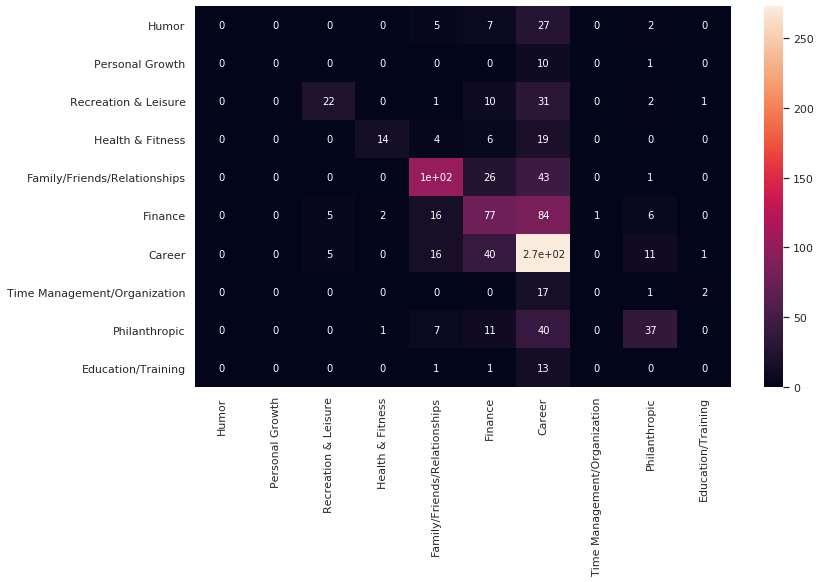

In [0]:
# A nice confusion matrix using seaborn.
array = metrics.confusion_matrix(test[:,4], predicted_1)
plt.figure(figsize=(12,7))
sn.set(font_scale=1) # for x/y label size
sn.heatmap(array, annot=True, annot_kws={"size": 10}, xticklabels = categories, yticklabels = categories) # annot_kws is the size of the numbers.
plt.show()